In [1]:
# from adsorbate_slab_config_fixed_seed import AdsorbateSlabConfig
from ocdata.core import Adsorbate, Bulk, Slab 
from ocdata.utils import DetectTrajAnomaly
from ocdata.utils.vasp import write_vasp_input_files
from ocdata.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import LmdbDataset as LD
import torch 
import ase
import lmdb
import pickle
import yaml
import os
import uuid
from ase.io import read
from glob import glob
import numpy as np
from random import randint
import pandas as pd
from dscribe.descriptors import SOAP
from ase.io.trajectory import Trajectory
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Slab vasp inputs

In [2]:
# miller_idx_list = [(2,2,1), (3,1,1), (3,2,1), (3,3,1), (3,1,0), (4,3,1), (4,1,0), (4,3,3), (4,3,2), (5,3,1), (5,4,3), (5,4,4), (5,2,1), (5,3,0), (5,5,1),
# (5,3,2),(5,5,3),(5,5,4),(5,1,1),(5,2,3),(6,4,1),(6,3,2),(6,5,1),(6,1,1),(6,5,3),(6,4,3),(6,6,4)]
# for miller_idx in tqdm(miller_idx_list): 
#     bulk = Bulk(bulk_src_id_from_db = "mp-30",
#             bulk_db_path = "../Open-Catalyst-Dataset/ocdata/databases/pkls/bulks.pkl")
#     slabs = Slab.from_bulk_get_specific_millers(miller_idx, bulk = bulk,)
#     atoms = slabs[0].atoms
#     write_vasp_input_files(atoms, outdir = f"vasp/slabs/mp_30_{miller_idx[0]}_{miller_idx[1]}_{miller_idx[2]}")

## Adslab vasp inputs -- AdsorbML

In [3]:
a2g = AtomsToGraphs(
    max_neigh=50,
    radius=6,
    r_energy=False,    # False for test data
    r_forces=False,    # False for test data
    r_distances=False,
    r_fixed=True,
)
ml_relax_db = lmdb.open(
    "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/ml_relax/adsorbml_relax_3.lmdb",
    map_size=1099511627776 * 2,
    subdir=False,
    meminit=False,
    map_async=True,
)

In [80]:
# miller_idx_list = [(2,2,1), (3,1,1), (3,2,1), (3,3,1), (3,1,0), (4,3,1), (4,1,0), (4,3,3), (4,3,2), (5,3,1), (5,4,3), (5,4,4), (5,2,1), (5,3,0), (5,5,1),
# (5,3,2),(5,5,3),(5,5,4),(5,1,1),(5,2,3),(6,4,1),(6,3,2),(6,5,1),(6,1,1),(6,5,3),(6,4,3),(6,6,4)]
miller_idx_list = [(3,2,2), (3,3,2), (2, 3, 2), (4,5,4)]
idx = 0
for miller_idx in tqdm(miller_idx_list): 
        bulk = Bulk(bulk_src_id_from_db = "mp-30",
        bulk_db_path = "/home/jovyan/shared-scratch/kabdelma/Open-Catalyst-Dataset/ocdata/databases/pkls/bulks.pkl")
        slabs = Slab.from_bulk_get_specific_millers(miller_idx, bulk = bulk,)
        slab = slabs[0]
        # oxygen molecule adsorbate
        adsorbate = Adsorbate(adsorbate_id_from_db=86, adsorbate_db_path = "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/updated_adsorbates.pkl")
        adsorbate.atoms.rotate(-90, 'y')
        adslab_heuristic  = AdsorbateSlabConfig(slab, adsorbate, mode= "random_site_heuristic_placement")
        adslabs = [*adslab_heuristic.atoms_list]
        sid = str(miller_idx[0]) + str(miller_idx[1]) + str(miller_idx[2])
        fid = 0
        for atoms in adslabs: 
                image = a2g.convert(atoms)
                # image.y = 0
                # image.force  = torch.tensor(atoms.get_forces())
                image.sid = torch.LongTensor([int(sid+str(fid))])
                image.fid = torch.LongTensor([fid])
                fid += 1
                # set the tags
                tags = np.ones(len(atoms))
                # set the adsorbate tag (last index) to 2
                tags[-1] = 2
                tags[-2] = 2
                image.tags = torch.LongTensor(tags)
                image.oc22=1
                # Write to LMDB
                txn = ml_relax_db.begin(write=True)
                txn.put(f"{idx}".encode("ascii"), pickle.dumps(image, protocol=-1))
                txn.commit()
                ml_relax_db.sync()
                idx += 1
        
txn = ml_relax_db.begin(write=True)
txn.put(f"length".encode("ascii"), pickle.dumps(idx, protocol=-1))
txn.commit()
ml_relax_db.sync()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [12:17<00:00, 147.45s/it]


In [81]:
dataset = LD({"src": "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/ml_relax/adsorbml_relax_3.lmdb"})
dataset[1].sid

tensor([3221])

In [32]:
base_yaml_path = "/home/jovyan/shared-scratch/kabdelma/ocp/configs/oc22/s2ef/base_joint.yml"
base_yaml = yaml.safe_load(
        open(base_yaml_path, "r")
    )
##
# del base_yaml["dataset"]["test"]
base_yaml["dataset"]["train"]["src"] = "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/train"
base_yaml["dataset"]["val"]["src"] = "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/val"
base_yaml["dataset"]["test"] = {"src" : "/home/jovyan/shared-scratch/kabdelma/high_miller_idx/lmdbs/ml_relax/adsorbml_relax_3.lmdb"}
##
with open(base_yaml_path, "w") as f:
    yaml.dump(base_yaml, f, default_flow_style=False)

## Check for anomalies

In [35]:
# Iterate over trajs to extract results
results = []
for file in tqdm(glob("/home/jovyan/shared-scratch/kabdelma/high_miller_idx/ml_relax_traj_3/*.traj")):
    rx_id = file.split("/")[-1].split(".")[0]
    traj = ase.io.read(file, ":")
    
    # Check to see if the trajectory is anomolous
    initial_atoms = traj[0]
    final_atoms = traj[-1]
    atom_tags = initial_atoms.get_tags()
    atom_tags[-1] = 2
    atom_tags[-2] = 2
    detector = DetectTrajAnomaly(initial_atoms, final_atoms, atom_tags)
    anom = (
        detector.is_adsorbate_dissociated()
        or detector.is_adsorbate_desorbed()
        or detector.has_surface_changed()
        or detector.is_adsorbate_intercalated()
    )
    rx_energy = traj[-1].get_potential_energy()
    results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
                    "relaxed_energy_ml": rx_energy, "anomolous": anom})  

100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


In [36]:
df = pd.DataFrame(results)
#scrap anomalies
df = df[~df.anomolous].copy().reset_index()
## get the Miller index from the relaxation index
for i in range(len(df)):
    miller_idx = int(df.iloc[i].relaxation_idx[:3])
    placement_num = int(df.iloc[i].relaxation_idx[3:])
    df.at[i, "miller_idx"] = miller_idx
    df.at[i, "placement_num"] = placement_num
df

,index,relaxation_idx,relaxed_atoms,relaxed_energy_ml,anomolous,miller_idx,placement_num
0,0,10020,"(Atom('Cu', [2.6006734371185303, 0.02133429236...",-203.763092,False,100.0,20.0
1,1,10059,"(Atom('Cu', [2.58103346824646, 0.0020765517838...",-203.766052,False,100.0,59.0
2,2,10070,"(Atom('Cu', [2.599041223526001, -0.00152928323...",-203.771088,False,100.0,70.0
3,3,10042,"(Atom('Cu', [2.6197001934051514, -0.0217799730...",-203.777161,False,100.0,42.0
4,4,10060,"(Atom('Cu', [2.620391368865967, -0.02184442989...",-203.778305,False,100.0,60.0
...,...,...,...,...,...,...,...
95,95,10077,"(Atom('Cu', [2.5975725650787354, -0.0077236834...",-203.774796,False,100.0,77.0
96,96,10065,"(Atom('Cu', [2.5998034477233887, 0.00116391107...",-203.764954,False,100.0,65.0
97,97,10012,"(Atom('Cu', [2.619626522064209, -0.02180602215...",-203.777832,False,100.0,12.0
98,98,10026,"(Atom('Cu', [2.5797533988952637, 0.02290132641...",-203.766998,False,100.0,26.0


## Deduplicate structures

In [37]:
# Extract the configs and their energies
def deduplicate(configs_for_deduplication: list,
                adsorbate_binding_index: int,
                cosine_similarity = 1e-4,
               ):
    """
    A function that may be used to deduplicate similar structures.
    Among duplicate entries, the one with the lowest energy will be kept.
    
    Args:
        configs_for_deduplication: a list of ML relaxed adsorbate-
            surface configurations.
        cosine_similarity: The cosine simularity value above which,
            configurations are considered duplicate.
            
    Returns:
        (list): the indices of configs which should be kept as non-duplicate
    """
    
    energies_for_deduplication = np.array([atoms.get_potential_energy() for atoms in configs_for_deduplication])
    # Instantiate the soap descriptor
    soap = SOAP(
        species=np.unique(configs_for_deduplication[0].get_chemical_symbols()),
        r_cut = 2,
        n_max = 6,
        l_max = 3,
        periodic=True,
    )
    #Figure out which index cooresponds to the adsorbate
    tags = configs_for_deduplication[0].get_tags()
    tags[-1] = 2
    ads_len = list(tags).count(2)
    position_idx = -1*(ads_len-adsorbate_binding_index)
    # Iterate over the systems to get the SOAP vectors
    soap_desc = []
    for config in configs_for_deduplication:
        soap_ex = soap.create(config, centers=[position_idx])
        soap_desc.extend(soap_ex)

    soap_descs = np.vstack(soap_desc)

    #Use euclidean distance to assess similarity
    distance = squareform(pdist(soap_descs, metric="cosine"))

    bool_matrix = np.where(distance <= cosine_similarity, 1, 0)
    # For configs that are found to be similar, just keep the lowest energy one
    idxs_to_keep = []
    pass_idxs = []
    for idx, row in enumerate(bool_matrix):
        if idx in pass_idxs:
            continue
            
        elif sum(row) == 1:
            idxs_to_keep.append(idx)
        else:
            same_idxs = [row_idx for row_idx, val in enumerate(row) if val == 1]
            pass_idxs.extend(same_idxs)
            # Pick the one with the lowest energy by ML
            min_e = min(energies_for_deduplication[same_idxs])
            idxs_to_keep.append(list(energies_for_deduplication).index(min_e))
    return idxs_to_keep

## Write vasp inputs for the 5 systems with the lowest energy

In [38]:
adsorbate = Adsorbate(adsorbate_id_from_db=0, adsorbate_db_path = "/home/jovyan/shared-scratch/kabdelma/Open-Catalyst-Dataset/ocdata/databases/pkls/adsorbates.pkl")
for miller in tqdm(np.unique(df.miller_idx)):
    df_miller = df.query(f"miller_idx == {miller}").copy()
    df_miller.sort_values(by = "placement_num", inplace = True)
    configs_for_deduplication =  df_miller.relaxed_atoms.tolist()
    idxs_to_keep = deduplicate(configs_for_deduplication, adsorbate.binding_indices[0])
    df_miller = df_miller.iloc[idxs_to_keep]
    lowest_energy_atoms = df_miller.sort_values(by = "relaxed_energy_ml")["relaxed_atoms"].iloc[:5].values
    print(len(np.where(lowest_energy_atoms[0].numbers==29)[0]))
    # Vasp parameters.
    vasp_flags = {
    "ibrion": 2,
    "nsw": 2000,
    "isif": 0,
    "isym": 0,
    "lreal": "Auto",
    "ediffg": -0.03,
    "symprec": 1e-10,
    "encut": 350.0,
    "laechg": True,
    "lwave": False,
    "ncore": 4,
    "gga": "RP",
    "pp": "PBE",
    "xc": "PBE",
    "ispin": 2,
    'magmom': [0]*len(np.where(lowest_energy_atoms[0].numbers==29)[0]) + [-2,2]
    }

    for i, atoms in enumerate(lowest_energy_atoms):
        write_vasp_input_files(atoms, outdir = f"vasp/adslabs_o2/mp_30_{int(miller)}_{i}", vasp_flags = vasp_flags)

100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

64


In [65]:
# dff = df.query("miller_idx == 643")
# dff.sort_values(by = "placement_num", inplace = True)
# adsorbate = Adsorbate(adsorbate_id_from_db=0, adsorbate_db_path = "/home/jovyan/shared-scratch/kabdelma/Open-Catalyst-Dataset/ocdata/databases/pkls/adsorbates.pkl")
# configs_for_deduplication =  dff.relaxed_atoms.tolist()
# idxs_to_keep = deduplicate(configs_for_deduplication, adsorbate.binding_indices[0])
# dff = dff.iloc[idxs_to_keep]
# dff.sort_values(by = "relaxed_energy_ml").iloc[:5]

## write the vasp output to traj files

### create a mapping file for the systems 

In [104]:
## load the mappings stored from previous experiments
with open('hif_vasp_mappings.pkl', 'rb') as read_file:
    hif_vasp_mappings = pickle.load(read_file)

## adslabs

In [105]:
## write traj files for adslab opt data
file_names = os.listdir("/home/jovyan/shared-scratch/kabdelma/high_miller_idx/vasp/adslabs_o2")
vasp_mappings = {}
for file_name in tqdm(file_names):
    atoms_list = read(f"/home/jovyan/shared-scratch/kabdelma/high_miller_idx/vasp/adslabs_o2/"+file_name + "/OUTCAR", ":")

    random_id = randint(1000,99999)
    traj_name = str(random_id) + ".traj"
    miller_idx = int(file_name.split("_")[-2])
    placement_num = int(file_name.split("_")[-1])
    mapping = {"mp-id": "mp-30",
               "miller_idx": miller_idx,
               "adsorbate": "O2",
               "adsorbate_placement_num": placement_num,
               "slab_id": None,
            }
    if mapping not in hif_vasp_mappings.values():
        with Trajectory(filename="vasp_traj_files/adslabs/" + traj_name, mode='w') as traj:
            for atoms in atoms_list:
                traj.write(atoms, **atoms.calc.results)
        vasp_mappings[random_id] = mapping
    else: 
        print(mapping)

  0%|          | 0/168 [00:00<?, ?it/s]

100%|██████████| 168/168 [00:13<00:00, 12.77it/s]


In [106]:
# update the mappings dictionary with the new experiments
hif_vasp_mappings.update(vasp_mappings)
# ## storing the meta-data in a json file
with open('hif_vasp_mappings.pkl', 'wb') as fout:
    pickle.dump(hif_vasp_mappings, fout)

## slabs

In [98]:
## load the mappings stored from previous experiments
with open('hif_vasp_mappings.pkl', 'rb') as read_file:
    hif_vasp_mappings = pickle.load(read_file)

In [99]:
## write traj files for adslab opt data
file_names = os.listdir("/home/jovyan/shared-scratch/kabdelma/high_miller_idx/vasp/slabs")
vasp_mappings = {}
for file_name in tqdm(file_names):
    atoms_list = read(f"/home/jovyan/shared-scratch/kabdelma/high_miller_idx/vasp/slabs/"+ file_name + "/OUTCAR", ":")
    random_id = randint(1000,99999)
    traj_name = str(random_id) + ".traj"
    miller_idx = int(file_name.split("_")[-3]+ file_name.split("_")[-2]+ file_name.split("_")[-1])
    placement_num = None
    mapping = {"mp-id": "mp-30",
               "miller_idx": miller_idx,
               "adsorbate": None,
               "adsorbate_placement_num": placement_num,
               "slab_id": None,
            }
    if mapping not in hif_vasp_mappings.values():
        with Trajectory(filename="vasp_traj_files/slabs/" + traj_name, mode='w') as traj:
            for atoms in atoms_list:
                traj.write(atoms, **atoms.calc.results)
        vasp_mappings[random_id] = mapping
    else: 
        print(mapping)

100%|██████████| 32/32 [00:06<00:00,  4.80it/s]


In [100]:
# update the mappings dictionary with the new experiments
hif_vasp_mappings.update(vasp_mappings)
# ## storing the meta-data in a json file
with open('hif_vasp_mappings.pkl', 'wb') as fout:
    pickle.dump(hif_vasp_mappings, fout)

In [107]:
## load the mappings stored from previous experiments
with open('hif_vasp_mappings.pkl', 'rb') as read_file:
    hif_vasp_mappings = pickle.load(read_file)

In [108]:
## match the slab and adslab ids in the mapping file
# find the slab mappings by finding dicts with adsorbate = None
slab_mappings = {k:v for k,v in hif_vasp_mappings.items() if v["adsorbate"] == None}
adslab_mappings = {k:v for k,v in hif_vasp_mappings.items() if v["adsorbate"] != None}
# match the adslab mappings with the slab mappings based on the miller index
for adslab_id, adslab_mapping in adslab_mappings.items():
    miller_idx = adslab_mapping["miller_idx"]
    for k,v in slab_mappings.items():
        if v["miller_idx"] == miller_idx:
            slab_id = k
            adslab_mappings[adslab_id]["slab_id"] = slab_id

In [109]:
# update the mappings dictionary with the new experiments
hif_vasp_mappings.update(adslab_mappings)
# ## storing the meta-data in a json file
with open('hif_vasp_mappings.pkl', 'wb') as fout:
    pickle.dump(hif_vasp_mappings, fout)

## Analysis

In [42]:
## load the mappings stored from previous experiments
with open('hif_vasp_mappings.pkl', 'rb') as read_file:
    hif_vasp_mappings = pickle.load(read_file)

In [73]:
# get the slab and the adslab realxed energies
traj_files = os.listdir("vasp_traj_files/adslabs")
miller_indices = []
placement_num = []
relax_adslab_energies = []
relax_slab_energies = []
sids = []
for traj_file in tqdm(traj_files):
    relaxed_adslab_atoms = read(f"vasp_traj_files/adslabs/{traj_file}", -1)
    slab_id = hif_vasp_mappings[int(traj_file.split(".")[0])]["slab_id"]
    if slab_id != None:
        sids.append(int(traj_file.split(".")[0]))
        relaxed_slab_atoms = read("vasp_traj_files/slabs/" + str(slab_id) + ".traj", -1)
        miller_idx = hif_vasp_mappings[int(traj_file.split(".")[0])]["miller_idx"]
        placement = hif_vasp_mappings[int(traj_file.split(".")[0])]["adsorbate_placement_num"]
        miller_indices.append(miller_idx)
        placement_num.append(placement)
        relax_adslab_energies.append(relaxed_adslab_atoms.get_potential_energy())
        relax_slab_energies.append(relaxed_slab_atoms.get_potential_energy())

100%|██████████| 435/435 [00:06<00:00, 67.40it/s]


In [99]:
vasp_df = pd.DataFrame({"sid": sids, "miller_idx": miller_indices, "placement_num": placement_num, 
                        "relax_adslab_energies": relax_adslab_energies,
                        "relax_slab_energies": relax_slab_energies,
                        })

oxygen_gas_phase_energy = -4.795631525
vasp_df["adsorption_energy"] = vasp_df["relax_adslab_energies"] - vasp_df["relax_slab_energies"] - oxygen_gas_phase_energy
miller_df = vasp_df.query("miller_idx == 321")
miller_df.drop_duplicates(subset = ["relax_adslab_energies"], inplace=True)
miller_df.sort_values(by = "relax_adslab_energies", inplace=True)
miller_df

,sid,miller_idx,placement_num,relax_adslab_energies,relax_slab_energies,adsorption_energy
260,68480,321,36,-250.438149,-244.021962,-1.620556
61,85152,321,36,-250.195445,-244.021962,-1.377852
324,86036,321,36,-250.117476,-244.021962,-1.299883
152,18638,321,36,-250.037766,-244.021962,-1.220173
2,45384,321,36,-250.020518,-244.021962,-1.202925


In [45]:
## for each Miller index get the lowest energy of the different palcements
lowest_ads_energies = {}
for miller in tqdm(np.unique(vasp_df.miller_idx)):
    miller_df = vasp_df.query(f"miller_idx == {miller}").copy()
    lowest_ads_energies[str(miller)] = miller_df["relax_adslab_energies"].values.min() - miller_df["relax_slab_energies"].values.min()

100%|██████████| 32/32 [00:00<00:00, 700.87it/s]


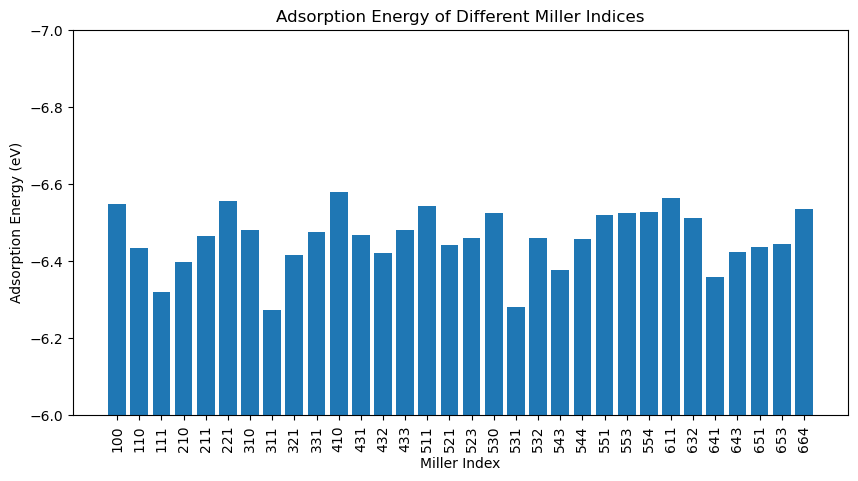

In [46]:
# sort the energies in the dictionary and plot
plt.figure(figsize=(10, 5))
plt.bar(lowest_ads_energies.keys(), lowest_ads_energies.values())
plt.xticks(list(lowest_ads_energies.keys()), rotation = 90)
plt.xlabel("Miller Index")
plt.ylabel("Adsorption Energy (eV)")
plt.ylim(-6,-7)
plt.title("Adsorption Energy of Different Miller Indices");

In [37]:
# atoms = miller_df["relaxed_atoms"].iloc[4]
# from ase.visualize import view
# view(atoms.repeat((2,2,1)), viewer='x3d')